In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
def income_bracket_mapping(x, income_to_weight):
    
    for income, weight in income_to_weight.items():
        if x>=income[0] and x<income[1]:
            return weight

def generate_weight_mapping(county_name, income_to_weight):
    filename = PROJECT_ROOT/"Data"/f"usa_va_{county_name}_adult_activity_location_assignment_week.csv"
    df_county = pd.read_csv(filename)[['pid', 'hid']]

    filename = PROJECT_ROOT/"Data"/"va_household.csv"
    df = pd.read_csv(filename)
    df['income'] = df['hh_income']/df['hh_size']
    
    df['income_group'] = df['income'].apply(lambda x: income_bracket_mapping(x, income_to_weight))
    
    df_hid = df.set_index('hid')
    df_county = df_county.join(df_hid, on='hid')
    df_county = df_county[['hid', 'pid', 'income', 'income_group']].groupby(['pid']).mean()
    
    print([sum(df_county['income_group']==val) for val in income_to_weight.values()])
    
    return df_county['income_group'].to_dict()

In [57]:
pid_weight_map = generate_weight_mapping("albemarle", {(0, 10275):1, (10275, 41775):2, (41775, 1e10):3})

[8320, 37750, 28183]


In [67]:
def cover_pid_group(fac_loc, loc_assignment, location_directory, pid_weight_map, radius):
    
    cover_count = 0
    fac_coord = (location_directory[fac_loc]["latitude"], location_directory[fac_loc]["longitude"])
    
    coverage = set()
    
    for ind in range(len(loc_assignment)):
        loc = loc_assignment[ind]
        pid = loc[0]
        pid_weight = pid_weight_map[pid]
        lid = loc[1]
        
        lid_coord = (location_directory[lid]["latitude"], location_directory[lid]["longitude"])
        if calculate_dist(fac_coord, lid_coord) <= pid_weight * radius:
            cover_count += 1
            coverage.add(loc[0])

    return cover_count, coverage

def initialize_timestep_group(pf, reachable, loc_assignments, location_directory, pid_weight_map, radius):
    
    if len(reachable) == 0:
        pf_count = 0
        coverage = set()
    else:
        pf_count, coverage = cover_pid_group(pf, loc_assignments, location_directory, pid_weight_map, radius)
    
    return (pf, pf_count, coverage)

def cover_fac_sequential_r_group(potential_facilities, location_directory, pid_assignment, pid_weight_map, reachable_dict, k_facs, radius):
    
    paths = []
    total_coverage = 0
    
    START_OFFSET = min(pid_assignment.keys())
    END_TIME = max(pid_assignment.keys())
    
    dp = {START_OFFSET-1: {pf: {"count": 0, "path": []} for pf in potential_facilities}}
    fac_client = {}

    for k in range(0, k_facs):
        
        for hr in range(START_OFFSET, END_TIME+1):
            
            dp[hr] = {}
            loc_assignments = pid_assignment[hr]
            
            if k==0:
                results = [initialize_timestep_group(pf, [r for r in reachable_dict[pf] if r in location_directory.keys()], loc_assignments, location_directory, pid_weight_map, radius) for pf in potential_facilities]
                
                fac_client[hr] = {fac: {"count": count, "coverage": coverage} for fac, count, coverage in results}

            chosen_max = [fill_timestep(pf, [r for r in reachable_dict[pf] if r in location_directory.keys()], loc_assignments, dp[hr-1]) for pf in potential_facilities]
            
            for pf, max_count, max_path in chosen_max:
                dp[hr][pf] = {"count":max_count + fac_client[hr][pf]["count"],
                                 "path": max_path + [pf]}

        best_count, best_path = max([(dp[hr][fac]["count"], dp[hr][fac]["path"]) for fac in potential_facilities])
        paths.append(best_path)

        for i, fac in enumerate(best_path):
            
            h = i + START_OFFSET
            
            covered_clients = fac_client[h][fac]["coverage"]
            
            for pf in potential_facilities:
                fac_client[h][pf]["coverage"] = fac_client[h][pf]["coverage"].difference(covered_clients)
                fac_client[h][pf]["count"] = len(fac_client[h][pf]["coverage"])
            
            fac_client[h][fac]["coverage"] = set()
            fac_client[h][fac]["count"] = 0
        
        total_coverage += best_count
    
    return total_coverage, paths

def cover_fac_kary_group(potential_facilities, location_directory, pid_assignment, pid_weight_map, m, k_facs, lower_limit = 0.5, upper_limit = 3, n_jobs = 40):

    l = lower_limit
    r = upper_limit
    
    epsilon = 2e-3
    alpha = 1
    
    radius_paths = []
    opt_radius = r
    total_clients = sum(len(val) for val in pid_assignment.values())
    print("TOTAL CLIENTS: ", total_clients)
    
    reachable_dict = calculate_reachable(potential_facilities, location_directory, m)
    print("---CALCULATED REACHABLE FACILITIES---")
    
    while r-l > epsilon:
        
        partition = [l + i*(r - l)/(n_jobs+1) for i in range(n_jobs)]
        
        result = Parallel(n_jobs=n_jobs)(delayed(cover_fac_sequential_r_group)(potential_facilities, location_directory, pid_assignment, pid_weight_map, reachable_dict, k_facs, mid) for mid in partition)
        
        coverage = [result[i][0] for i in range(n_jobs)]
        
        if max(coverage) < total_clients:
            l = l + n_jobs*(r - l)/(n_jobs+1)
        else:
            for i in range(n_jobs):
                if coverage[i] >= total_clients:
                    radius_paths = result[i][1]
                    opt_radius = l + i*(r - l)/(n_jobs+1)
                    l = max(l, opt_radius - (r-l)/(n_jobs+1))
                    r = opt_radius
                    print(opt_radius)
                    break
    
    return opt_radius, radius_paths

In [68]:
def calculate_assignment_group(facilities, location_directory, pid_assignment, pid_weight_map):
    max_dist = 0
    
    group_assignment_costs = {}
    for val in pid_weight_map.values():
        group_assignment_costs[val] = {}
    
    START = min(pid_assignment.keys())
    END = max(pid_assignment.keys())
    
    for hr in range(START, END):
        for pid, client in pid_assignment[hr]:
            
            group = pid_weight_map[pid]
            
            coord_client = (location_directory[client]['latitude'], location_directory[client]['longitude'])
            client_cost = min([calculate_dist(coord_client, (location_directory[fac[hr-START]]['latitude'], location_directory[fac[hr-START]]['longitude'])) for fac in facilities])
            
            group_assignment_costs[group][pid] = client_cost
            
            if client_cost > max_dist:
                max_dist = client_cost
            
    return max_dist, group_assignment_costs

In [69]:
from FullyMobile.data import *
from FullyMobile.algorithm import *
from FullyMobile.utils import *
from FullyMobile import PROJECT_ROOT
import json
import os
import time

day = 5
start = 6
end = 20

potential_facilities, location_directory, pid_assignment = get_data("charlottesville_city", day, start, end)
print(len(potential_facilities), len(location_directory), sum(len(val) for val in pid_assignment.values()))

3142 13039 517


In [70]:
pid_weight_map = generate_weight_mapping("charlottesville_city", {(0, 10275):1, (10275, 41775):2, (41775, 1e10):3})

m = 5
k_facs = 5

radius, facs = cover_fac_kary_group(potential_facilities, location_directory, pid_assignment, pid_weight_map, m, k_facs)
obj, group_obj = calculate_assignment_group(facs, location_directory, pid_assignment, pid_weight_map)

[7584, 15443, 10129]
TOTAL CLIENTS:  517
---CALCULATED REACHABLE FACILITIES---
1.2317073170731707
1.215348007138608


In [71]:
print(obj)

3.574543654538191


In [73]:
from FullyMobile.algorithm import *
radius, facs = cover_fac_kary(potential_facilities, location_directory, pid_assignment, m, k_facs)

TOTAL CLIENTS:  517
---CALCULATED REACHABLE FACILITIES---
1.7804878048780488
1.7314098750743605


NameError: name 'facilities' is not defined

In [74]:
obj, unweighted_group_obj = calculate_assignment_group(facs, location_directory, pid_assignment, pid_weight_map)
print(obj)

1.731272254198698


In [80]:
dict_frame = {"obj": [], "class": [], "weighted": []}

for g in group_obj.keys():
    for pid, pid_obj in group_obj[g].items():
        dict_frame["class"].append(str(int(g)))
        dict_frame["obj"].append(pid_obj)
        dict_frame["weighted"].append(True)

for g in unweighted_group_obj.keys():
    for pid, pid_obj in unweighted_group_obj[g].items():
        dict_frame["class"].append(str(int(g)))
        dict_frame["obj"].append(pid_obj)
        dict_frame["weighted"].append(False)

<AxesSubplot:xlabel='obj', ylabel='class'>

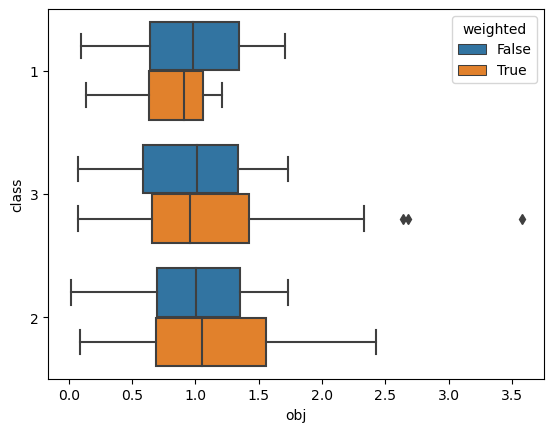

In [81]:
import seaborn as sns

df = pd.DataFrame(dict_frame)

sns.boxplot(data=df, x="obj", y="class", hue="weighted")

In [ ]:
from FullyMobile.algorithm import *
radius, facs = cover_fac_kary_group(potential_facilities, location_directory, pid_assignment, m, k_facs)
obj, group_obj = calculate_assignment_group(facilities, location_directory, pid_assignment, pid_weight_map)

In [2]:
from FullyMobile.data import *
from FullyMobile.algorithm import *
from FullyMobile.utils import *
from FullyMobile import PROJECT_ROOT
import json
import os
import time

day = 5
start = 6
end = 20

potential_facilities, location_directory, pid_assignment = get_data("albemarle", day, start, end, random_state=80830)
old_assign = pid_assignment
print(len(potential_facilities), len(location_directory), sum(len(val) for val in pid_assignment.values()))

6711 35645 1256


In [3]:
facs = iterative_supplier(potential_facilities, location_directory, pid_assignment, 5, 5, lower_limit = 0.1, upper_limit = 20)
print(calculate_assignment_cost(facs, location_directory, pid_assignment))

8.101782226562499 [98560, 1703952, 1704433, 98326, 67518]
8.953216552734373 [98560, 1703952, 1704433, 65652, 67518]
12.680822753906249 [333687, 1624843, 1704433, 98326, 67518]
8.067773437499998 [98560, 32804, 1704433, 98326, 67518]
10.581994628906251 [517468, 32804, 1704433, 98326, 67518]
8.020404052734373 [77416, 32804, 1704433, 98371, 517396]
7.844287109374999 [32896, 32804, 1704433, 98326, 1704324]
7.912304687499999 [32896, 622808, 1704433, 98326, 1704324]
8.786816406249999 [1703979, 32804, 2732780, 98326, 622922]
8.232958984375 [1703979, 32804, 34741, 98326, 622922]
7.094879150390623 [1703979, 32804, 34741, 98326, 1704324]
6.977062988281249 [1703979, 32804, 1704433, 98326, 1704324]
8.292474365234375 [1703979, 32804, 1704433, 98345, 1704324]
7.108239746093749 [1703979, 32804, 1810240, 32796, 1704324]
67.71955190164675


In [7]:
facilities = facs

In [13]:
max_dist = 0

START = min(pid_assignment.keys())
END = max(pid_assignment.keys())

for hr in range(START, END):
    for pid, client in pid_assignment[hr]:
        coord_client = (location_directory[client]['latitude'], location_directory[client]['longitude'])
        
        min_pair = (10e9, -1)
        for fac in facilities:
            coord_fac = (location_directory[fac[hr-START]]['latitude'], location_directory[fac[hr-START]]['longitude'])
            dist = calculate_dist(coord_client, coord_fac)
            if dist<min_pair[0]:
                min_pair = (dist, coord_fac)
        
        if min_pair[0] > max_dist:
            max_dist = min_pair[0]
            print(max_dist, coord_client, min_pair[1])

7.404081625669087 (38.0851947721032, -78.2433019604613) (38.05423, -78.31818)
8.021067556934971 (37.9974202429428, -78.3746123197011) (38.05423, -78.31818)
11.789023060999934 (37.9902669512309, -78.7860372409287) (37.956540000000096, -78.65853)
17.017359214615954 (37.8827270284028, -78.4470153350547) (38.0317900000001, -78.49098)
17.172989196055966 (38.13516, -78.70483) (38.1392035, -78.508542)
18.41874159210206 (38.0613643472414, -78.7564774362041) (37.9288884380528, -78.6302972073391)
67.71955190164675 (37.2646800000001, -78.41151) (37.8467325, -78.6375665)


In [12]:
with open(PROJECT_ROOT/"Experiments"/"output"/"movement_sensitivity"/"baseline"/"albe_movement_budget_pt2_85745.json") as f:
    data = json.load(f)

with open(PROJECT_ROOT/"Experiments"/"output"/"movement_sensitivity"/"baseline"/"albe_movement_budget_pt3_85745.json") as f:
    data_supp = json.load(f)
    
with open(PROJECT_ROOT/"Experiments"/"output"/"movement_sensitivity"/"baseline"/"albe_movement_budget_pt2_85745_fixed.json", 'w') as f:
    total_runs = data["baseline_runs"]
    total_runs["7.5"] = data_supp["baseline_runs"]["7.5"]
    total_runs["8.0"] = data_supp["baseline_runs"]["8.0"]
    data_supp = json.dump({"seed": data["seed"], "baseline_runs": total_runs}, f)

In [4]:
def calculate_capacity_redistribution(facilities, location_directory, pid_assignment):
    max_dist = 0
    
    START = min(pid_assignment.keys())
    END = max(pid_assignment.keys())
    
    for hr in range(START, END):
        clients = set(client[1] for client in pid_assignment[hr])
        radius = redistribute([facilities[i][hr-START] for i in range(len(facilities))], location_directory, clients)
        
        if radius > max_dist:
            max_dist = radius
        print(hr, radius)
    
    return max_dist

In [27]:
import math

def redistribute(facilities, location_directory, clients):
    facility_to_clients = {fac:[] for fac in facilities}
    client_facility_distances = {}
    
    max_dist = 0
    
    for c in clients:
        coord_client = (location_directory[c]['latitude'], location_directory[c]['longitude'])
        
        client_facility_distances[c] = {}
        
        min_fac = (10e9, -1)
        for fac in facilities:
            coord_fac = (location_directory[fac]['latitude'], location_directory[fac]['longitude'])
            distance = calculate_dist(coord_client, coord_fac)
            if distance < min_fac[0]:
                min_fac = (distance, fac)
            
            client_facility_distances[c][fac] = distance
        
        facility_to_clients[min_fac[1]].append(c)
        
        if min_fac[0] > max_dist:
            max_dist = min_fac[0]
    
    constraint = math.ceil(len(clients)/len(facilities))
    CAPACITY = {fac: constraint*facilities.count(fac) for fac in facilities}
    
    facility_counts = {fac: len(c) for fac, c in facility_to_clients.items()}
    facility_excess = {fac: facility_counts[fac]-CAPACITY[fac] for fac in facility_counts.keys()}
    print(facility_counts, CAPACITY)
    
    #print(facility_counts, facility_excess, CAPACITY)
    
    largest_fac = max(facility_excess, key=facility_excess.get)
    
    counter = 0
    
    while facility_counts[largest_fac] > CAPACITY[largest_fac]:
        
        redist_choice = []
        for c in facility_to_clients[largest_fac]:
            options = [(val, key) for key, val in client_facility_distances[c].items() if key!=largest_fac and facility_excess[largest_fac]-facility_excess[key]>1]
            if len(options)>0:
                min_option = min(options)
                redist_choice.append((min_option[0], min_option[1], c))

        dist, fac, client = min(redist_choice)

        facility_to_clients[largest_fac].remove(client)
        facility_counts[largest_fac]-=1
        facility_excess[largest_fac]-=1

        facility_to_clients[fac].append(client)
        facility_counts[fac]+=1
        facility_excess[fac]+=1

        counter += 1
        
        largest_fac = max(facility_excess, key=facility_excess.get)
        
    print(facility_counts, CAPACITY)
    
    return max(client_facility_distances[c][fac] for fac, assigned_clients in facility_to_clients.items() for c in assigned_clients)

In [28]:
from FullyMobile.data import get_data

cover_runs = [run for run in os.listdir(PROJECT_ROOT/"Experiments"/"output"/"budget_sensitivity"/"cover") if run.endswith('.json') and "cville" in run]

k = 5

with open(PROJECT_ROOT/"Experiments"/"output"/"budget_sensitivity"/"cover"/cover_runs[9]) as f:
    data = json.load(f)
    seed = data[0]
    data = data[1]
    facilities = data[str(k)]["paths"]
    
    potential_facilities, location_directory, pid_assignment = get_data("charlottesville_city", day, start, end, random_state=seed)
    print("INITIAL: ", calculate_assignment_cost(facilities, location_directory, pid_assignment))
    
    #print(len(potential_facilities), len(location_directory), sum(len(val) for val in pid_assignment.values()))

    print("FINAL: ", calculate_capacity_redistribution(facilities, location_directory, pid_assignment))

INITIAL:  1.6881551203227323
{2047809: 16, 2732562: 18, 123144: 7, 2732535: 6, 2732510: 20} {2047809: 14, 2732562: 14, 123144: 14, 2732535: 14, 2732510: 14}
{2047809: 14, 2732562: 14, 123144: 14, 2732535: 11, 2732510: 14} {2047809: 14, 2732562: 14, 123144: 14, 2732535: 14, 2732510: 14}
6 3.682934249609197
{42305: 17, 623016: 11, 2732510: 13, 2732562: 5, 2732488: 8} {42305: 11, 623016: 11, 2732510: 11, 2732562: 11, 2732488: 11}
{42305: 11, 623016: 11, 2732510: 11, 2732562: 10, 2732488: 11} {42305: 11, 623016: 11, 2732510: 11, 2732562: 11, 2732488: 11}
7 3.3315601511679374
{2653281: 20, 2732575: 5, 42182: 6, 2285179: 4, 2732583: 4} {2653281: 8, 2732575: 8, 42182: 8, 2285179: 8, 2732583: 8}
{2653281: 8, 2732575: 8, 42182: 8, 2285179: 7, 2732583: 8} {2653281: 8, 2732575: 8, 42182: 8, 2285179: 8, 2732583: 8}
8 3.600666627921077
{2258513: 7, 2732510: 14, 2232373: 9, 2732535: 3, 2732488: 7} {2258513: 8, 2732510: 8, 2232373: 8, 2732535: 8, 2732488: 8}
{2258513: 8, 2732510: 8, 2232373: 8, 27325

In [162]:
def flow(potential_facilities, location_directory, pid_assignment, k, m, lower_limit = 0.1, upper_limit = 20):
        
    l = lower_limit
    r = upper_limit

    to_ret = -1
    ret_facilities = []
    EPSILON = 2e-3
    
    while r-l > EPSILON:
    
        mid = l + (r - l) / 2
        
        client_balls = {}
        good_radius = True
        
        for t in pid_assignment.keys():
            clients = {c for pid,c in pid_assignment[t]}
            pairwise_disjoint = _check_radius(location_directory, mid, clients)
            
            if len(pairwise_disjoint)>k:
                good_radius = False
                break
            
            client_balls[t] = pairwise_disjoint

        if good_radius:
            facilities = build_flow(potential_facilities, location_directory, client_balls, k, m, mid)

            if facilities:
                to_ret = mid
                r = mid
                ret_facilities = facilities
                print(mid, len(facilities))
            else:
                print(mid, "INFEASIBLE")
                l = mid
        
        else:
            print(mid, "IND SETS")
            l = mid
    
    return to_ret, ret_facilities, client_balls

In [31]:
from scipy.sparse import csr_matrix

In [43]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_flow

def build_flow(potential_facilities, location_directory, client_balls, k, m, radius):
    
    fac_to_clients = {}
    
    for pf in potential_facilities:
        fac_to_clients[pf] = {}
        coord1 = (location_directory[pf]["latitude"], location_directory[pf]["longitude"])
        
        for t, clients in client_balls.items():
            fac_to_clients[pf][t] = set()
            
            for c in clients:
                coord2 = (location_directory[c]["latitude"], location_directory[c]["longitude"])
                dist = calculate_dist(coord1, coord2)
                if dist <= radius:
                    fac_to_clients[pf][t].add(c)
    
    #print("calculated client ball assignment")
    reachable = calculate_reachable(potential_facilities, location_directory, m)

    data = []
    indices = []
    indptr = [0]
    
    node_to_ind = {}
    count = 0
    for t in client_balls.keys():
        node_to_ind[t] = {"fac_in": {}, "client_in": {}, "client_out": {},"fac_out":{}}
        for pf in potential_facilities:
            node_to_ind[t]["fac_in"][pf] = count
            count += 1
        for c in client_balls[t]:
            node_to_ind[t]["client_in"][c] = count
            count += 1
        for c in client_balls[t]:
            node_to_ind[t]["client_out"][c] = count
            count += 1
        for pf in potential_facilities:
            node_to_ind[t]["fac_out"][pf] = count
            count += 1
    
    #s, t, s', t' have not been accounted for yet...
    S_STAR = count
    S_NODE = S_STAR+1
    T_NODE = S_NODE+1
    S_PRIME = T_NODE+1
    T_PRIME = S_PRIME+1
    
    for t in client_balls.keys():
        client_to_fac = {}
        for pf in potential_facilities:
            connection_count = 0
            
            # does not pass through client ball
            if len(fac_to_clients[pf][t])== 0:
                
                connection_count += 1
                data.append(k)
                indices.append(node_to_ind[t]["fac_out"][pf])
                
            # passes through client ball
            for c in fac_to_clients[pf][t]:
                
                if c not in client_to_fac.keys():
                    client_to_fac[c] = [pf]
                else:
                    client_to_fac[c].append(pf)
                
                connection_count += 1
                indices.append(node_to_ind[t]["client_in"][c])
                data.append(k)
            
            indptr.append(indptr[-1] + connection_count)
        
        for c in client_balls[t]:
            # may be another larger capacity...
            data.append(k)
            indices.append(node_to_ind[t]["client_out"][c])
            
            # add connection to t'
            data.append(1)
            indices.append(T_PRIME)
            indptr.append(indptr[-1]+2)
        
        for c in client_balls[t]:
            connection_count = 0
            for fac in client_to_fac[c]:
                indices.append(node_to_ind[t]["fac_out"][fac])
                data.append(k)
                connection_count += 1
            indptr.append(indptr[-1]+connection_count)
        
        for pf in potential_facilities:
            if t == max(client_balls.keys()):
                #add connections to t
                data.append(k)
                indices.append(T_NODE)
                indptr.append(indptr[-1]+1)
            else:
                connection_count = 0
                for fac in reachable[pf]:
                    indices.append(node_to_ind[t+1]["fac_in"][fac])
                    data.append(k)
                    connection_count += 1
                indptr.append(indptr[-1]+connection_count)
    
    saturation = 0
    
    # add constraint on total flow
    data.append(k)
    indices.append(T_PRIME)
    indptr.append(indptr[-1]+1)
    
    # add s edges
    #row_count += 1
    data += [k for _ in range(len(potential_facilities))]
    indices += [node_to_ind[min(client_balls.keys())]["fac_in"][fac] for fac in potential_facilities]
    indptr.append(indptr[-1]+len(potential_facilities))
    
    # add t edge (going back into s*)
    #row_count += 1
    data.append(k)
    indices.append(S_STAR)
    indptr.append(indptr[-1]+1)
    
    # add s' edges
    #row_count += 1
    connection_count = 0
    for t in client_balls.keys():
        for client, indx in node_to_ind[t]["client_out"].items():
            connection_count += 1
            indices.append(indx)
            data.append(1)
    
    data.append(k)
    indices.append(S_NODE)
    
    indptr.append(indptr[-1]+connection_count + 1)
    saturation = connection_count + k
    
    # add t' edges
    #row_count += 1
    indptr.append(indptr[-1])
    
    graph = csr_matrix((data, indices, indptr), shape=(T_PRIME+1, T_PRIME+1))
    flow = maximum_flow(graph, S_PRIME, T_PRIME, method='edmonds_karp')
    if flow.flow_value == saturation:
        #print("FEASIBLE!")
        #return flow.flow
        fac = open_facilities(graph[:,:S_STAR], flow.flow[:,:S_STAR], node_to_ind, fac_to_clients, potential_facilities, client_balls, S_NODE)
        return fac
    else:
        return

In [38]:
import numpy as np
def open_facilities(graph, flow, node_to_ind, fac_to_clients, potential_facilities, client_balls, S_NODE):
    
    facility_paths = []
    
    while len((flow[S_NODE]>0).indices) > 0:
        
        path = []
        
        fac = (flow[S_NODE]>0).indices[0]
        flow[S_NODE, fac]-=1
        
        t = min(client_balls.keys())
        ind_to_node = {ind: node for node, ind in node_to_ind[t]["fac_in"].items()}
        
        path.append(ind_to_node[fac])
        
        while len(path)<len(client_balls.keys()):
            
            t += 1
            ind_to_node = {ind: node for node, ind in node_to_ind[t]["fac_in"].items()}
            
            previous_facility = path[-1]
            index = node_to_ind[t-1]["fac_in"][previous_facility]
            next_step = (flow[index]>0).indices[0]
            flow[index, next_step]-=1

            # does not flow through client ball
            if len(fac_to_clients[previous_facility][t-1]) == 0:

                next_fac = (flow[next_step]>0).indices[0]

                flow[next_step, next_fac]-=1

            # it flows through a client ball
            else:
                next_client_ball = (graph[next_step]>0).indices[0]
                exit_node = (flow[next_client_ball]>0).indices[0]
                next_fac = (flow[exit_node]>0).indices[0]

                flow[next_client_ball, exit_node]-=1
                flow[exit_node, next_fac]-=1
        
            path.append(ind_to_node[next_fac])
        
        facility_paths.append(path)
        #print(facility_paths)
        
    return facility_paths
    

In [39]:
from FullyMobile.algorithm import _check_radius, _locate_facilities

In [40]:
k = 5
m = 5
radius, flow, client_balls = flow(potential_facilities, location_directory, pid_assignment, k, m, lower_limit = 0.1, upper_limit = 20)

10.049999999999999 5
5.074999999999999 5
2.5875 5
1.34375 5
0.7218749999999999 IND SETS
1.0328125 IND SETS
1.18828125 5
1.1105468749999998 IND SETS
1.1494140625 IND SETS
1.16884765625 5
1.159130859375 IND SETS
1.1639892578125002 IND SETS
1.1664184570312501 IND SETS
1.167633056640625 IND SETS


In [42]:
for j in range(len(client_balls.keys())):
    clients = client_balls[min(client_balls.keys())+j]
    for b in clients:
        coord2 = (location_directory[b]['latitude'], location_directory[b]['longitude'])
        
        isSuccessful = False
        for fac in set([flow[i][j] for i in range(len(flow))]):
            coord1 = (location_directory[fac]['latitude'], location_directory[fac]['longitude'])
            
            if calculate_dist(coord2, coord1)<=radius:
                isSuccessful=True
                break
        
        print(isSuccessful)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [12]:
print(fac)

(1.7102050781250002, [[122888, 2547840, 131099, 32795, 131099, 16445, 122888, 32795, 122888, 98326, 122888, 122888, 122888, 16447], [131099, 32795, 122888, 122888, 122888, 8233, 98326, 98326, 106561, 122888, 32795, 98326, 98326, 32795], [16445, 122888, 16450, 16450, 32795, 98326, 32795, 122888, 32795, 122888, 73758, 32795, 32795, 122888]])


In [10]:
for path in fac[1]:
    for i in range(1, len(path)):
        fac1 = path[i-1]
        fac2 = path[i]
        coord1 = (location_directory[fac1]["latitude"], location_directory[fac1]["longitude"])
        coord2 = (location_directory[fac2]["latitude"], location_directory[fac2]["longitude"])
        print(calculate_dist(coord1, coord2))

2.968483217968394
1.0065082104307448
1.4344847480314693
2.7627563349253115
1.5222899773388703
2.918938324844095
1.4150024222743056
2.3125334390899286
3.4102879505092676
1.3269517534086694
1.6677441015216707
4.243837774457177
3.319260623499233
3.2385531853787035
4.057827233449396
3.1827550953864807
0.0
3.5135434476145133
0.8225247344091408
4.23821657947764
2.5986764385632144
1.7400786190487003
2.938133405086034
0.0
2.9381334050860306
4.713846177292011
2.365319530026117
1.9188304311357396
0.0
0.0
0.0
0.0
0.0
2.938133405086034
2.9381334050860306
2.938133405086034
0.0
4.772324666380309
1.0114092049867136
0.3131056558814142
2.0453675689245836
2.8951650412700145
1.377762982351964
3.0468331289147392
3.2943369056828113
2.1073310916385437
4.736549012080406
3.9394047064004245
2.938133405086034
3.478690711917839
4.535436485870629
0.0
2.895124218939158
2.7230101606587107
4.4023128184799525
0.8387061481088598
0.0
1.2839647993094903
2.071285782914826
4.397777371367233
0.6944464082947369
3.2051529981

In [23]:
print(calculate_assignment_cost(flow[1], location_directory, pid_assignment))

1.766630214085124


In [31]:
print(len(fac[1]))

10


In [34]:
(np.ndarray(3),).flatten()

AttributeError: 'tuple' object has no attribute 'flatten'

In [50]:
#np.where(np.array([1,2])>1)
np.asarray(np.array([1,2])>1).nonzero()

(array([1]),)

In [160]:
print(fac)

(1.4972656250000003, [[98326, 98326, 98326, 73757, 32795, 131099, 16445, 49206, 122888, 73758, 122888, 73758, 98326, 131099]])


In [82]:
np.where(flow.toarray()[S_NODE,:]>0)

(array([0, 1, 2, 3, 5]),)

In [96]:
print(flow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import numpy
edges = flow.flow!=0
a = flow.flow.toarray()
print(sum(a[:, 88018]))
print(sum(a[88018,:]))

In [3]:
#from FullyMobile.lp import *
#lp = FlowLP(potential_facilities, location_directory, pid_assignment, 5, 5, 5)

In [4]:
#import time

#start = time.time()
#lp.solve_lp()
#end = time.time()

#print(end-start)

In [5]:
from FullyMobile.algorithm import _check_radius, _locate_facilities

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_bipartite_matching

def check_matching(potential_facilities, location_directory, previous_facilities, timestep_balls, k, m, radius):
    if len(previous_facilities) == 0:
        facilities: List[int] = _locate_facilities(location_directory, radius, timestep_balls, potential_facilities, k)
        return facilities
    else:
        distance_dict = {}
        
        data = []
        indices = []
        indptr = [0]
        
        for prev_iter, prev in enumerate(previous_facilities):
            coord_prev = (location_directory[prev]["latitude"], location_directory[prev]["longitude"])
            
            edge_count = 0
            
            for ball_iter, next_ball in enumerate(timestep_balls):
                
                coord_client = (location_directory[next_ball]["latitude"], location_directory[next_ball]["longitude"])
                
                for fac in potential_facilities:
                    coord_fac = (location_directory[fac]["latitude"], location_directory[fac]["longitude"])
                    if calculate_dist(coord_client, coord_fac) <= radius and calculate_dist(coord_prev, coord_fac) <= m:
                        distance_dict[(prev_iter, ball_iter)] = fac
                        
                        edge_count += 1
                        
                        data.append(1)
                        indices.append(ball_iter)
                        
                        break
            
            indptr.append(indptr[-1] + edge_count)
        
        graph = csr_matrix((data, indices, indptr), shape=(len(previous_facilities), len(timestep_balls)))
        match = maximum_bipartite_matching(graph, perm_type = 'column')
        
        if len(timestep_balls) >= len(previous_facilities) and (match == -1).sum() > 0:
            return {}
        else:
            fac = []
            for row, col in enumerate(match):
                if col!=-1:
                    fac.append(distance_dict[(row, col)])
                else:
                    fac.append(previous_facilities[row])
            return fac
        

In [7]:
def k_supplier_step(potential_facilities, location_directory, k, m, previous_facilities, clients, lower_limit = 0.1, upper_limit = 20):
    
    l = lower_limit
    r = upper_limit

    to_ret = -1
    ret_facilities = []
    EPSILON = 2e-3
    
    while r-l > EPSILON:
    
        mid = l + (r - l) / 2
        
        pairwise_disjoint = _check_radius(location_directory, mid, clients)

        if len(pairwise_disjoint) <= k:
            facilities = check_matching(potential_facilities, location_directory, previous_facilities, pairwise_disjoint, k, m, mid)
            
            if facilities:
                to_ret = mid
                r = mid
                ret_facilities = facilities
            else:
                l = mid
        
        else:
            l = mid
    
    return to_ret, ret_facilities

In [21]:
def baseline_supplier(potential_facilities, location_directory, pid_assignment, k: int, m: float, lower_limit = 0.1, upper_limit = 20):
    
    previous_facilities = []
    facility_paths = [[] for _ in range(k)]
    
    for hr, vals in pid_assignment.items():
        
        clients = set()
        for val in vals:
            clients.add(val[1])
        
        radius, timestep_facilities = k_supplier_step(potential_facilities, location_directory, k, m, previous_facilities, clients, lower_limit = lower_limit, upper_limit = upper_limit)
        
        print(radius, timestep_facilities)
        
        for i in range(len(facility_paths)):
            facility_paths[i].append(timestep_facilities[i])
        previous_facilities = timestep_facilities
    
    return facility_paths

In [17]:
facility_paths = baseline_supplier(potential_facilities, location_directory, pid_assignment, 10, 5)

0.6247070312499999 [2547840, 16450, 2547908, 1704166, 623016, 1466668, 49206, 89, 32795, 73757]
0.6332092285156249 [1466611, 82229, 73758, 131099, 98326, 2547876, 2547840, 73846, 98345, 16445]
0.49717407226562493 [2547895, 16445, 2547820, 65632, 8233, 2547839, 2547840, 2547776, 131099, 122888]
0.5518310546875 [106563, 65632, 16450, 1704107, 89, 1704155, 2547912, 2547797, 131152, 98326]
0.488671875 [16447, 122888, 2547895, 122966, 16450, 1704165, 16445, 8233, 254286, 32795]
0.523895263671875 [89, 2547887, 73757, 98405, 16446, 2547907, 1704155, 2547776, 49206, 73758]
0.5226806640625 [32795, 16446, 2547907, 1704165, 2547876, 2547839, 133931, 73846, 2547912, 122966]
0.604058837890625 [32795, 1704146, 98326, 1704166, 90175, 2547912, 89, 233, 16450, 82174]
0.5821960449218749 [2547806, 2547825, 122888, 90175, 886328, 991863, 133931, 2547839, 2547908, 1466668]
0.61256103515625 [65632, 1704155, 98405, 16450, 89, 131152, 2547840, 1704166, 49206, 73758]
0.570050048828125 [2547806, 32795, 131099, 

In [18]:
calculate_assignment_cost(facility_paths, location_directory, pid_assignment)

1.6607645701578895

In [19]:
print(len(facility_paths), len(facility_paths[0]))

10 14


In [20]:
for i in range(len(facility_paths)):
    for j in range(1, len(facility_paths[0])):
        coord1 = (location_directory[facility_paths[i][j]]["latitude"], location_directory[facility_paths[i][j]]["longitude"])
        coord2 = (location_directory[facility_paths[i][j-1]]["latitude"], location_directory[facility_paths[i][j-1]]["longitude"])
        print(calculate_dist(coord1, coord2))

4.9211829114622905
4.304594727914821
0.7126641139899595
1.049021866612541
2.6575238840645428
3.4018707836593864
0.0
3.3739931360373747
0.9251004550201813
0.9251004550202215
1.6699770738014648
4.21432252956719
4.822510095480924
2.9278907090080213
4.941963128253653
3.1827550953864807
2.2712234760891903
0.8181627493323282
3.1924351516794482
0.858964449128768
0.2834996029302072
1.7589133683801261
4.969938626167263
3.649866471215745
0.9937114488505862
4.217363382374605
4.629431066405123
3.6563241004017444
0.28690354642865284
2.9146327420982416
2.117034465096184
2.8895018348734705
1.9289388421760916
1.6677441015216876
4.3868707143790555
1.6155323377405784
0.8019527475364349
1.8624639915803491
1.6943990994416411
4.267343427822449
1.3066294762494899
1.5026592251920707
3.0903586992248617
3.7155110055769036
4.17854069329452
0.48419104782189604
4.2382165794776725
1.913817721791171
3.908189809226391
1.7400786190487003
0.46632602681079866
1.5168844520084623
2.9074537371651963
2.3784592652080514
3.2